# Decision Trees

Determine what product to suggest to current customers next (based on data of previous customers). <br>

They are interested in sending out promotional information on 4 different ’products’: 
- Brokerage Accounts
- Roth IRAs
- Term Deposits (CDs)
- Mortgage Refinance Offers

Determine which promotions to send to which individuals, but they are not ready to implement a fancy
real-time model with software. They’re looking for simple rules to guide them in their marketing assignments.

Resources used:
https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling and plotting
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.tree import plot_tree

# Accuracy metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

# Exporting results
import graphviz
import imageio
import pydotplus
import io

%matplotlib inline

In [2]:
# Import data as df
df = pd.read_csv(r'C:\Users\chely\Documents\Data Mining\HW2\bankData.csv')

In [3]:
# Remove y and duration variables; not needed in analysis!
df = df.drop(['y', 'duration'], axis=1)

In [4]:
# See data preview
df.head()

,age,job,marital,education,default,housing,loan,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,next.product,balance
0,56,housemaid,married,basic.4y,no,no,no,1.1,93.994,-36.4,4.857,5191.0,Roth,NaN
1,57,services,married,high.school,unknown,no,no,1.1,93.994,-36.4,4.857,5191.0,Roth,9133.569487
2,37,services,married,high.school,no,yes,no,1.1,93.994,-36.4,4.857,5191.0,None,7200.736396
3,40,admin.,married,basic.6y,no,no,no,1.1,93.994,-36.4,4.857,5191.0,None,5822.260428
4,56,services,married,high.school,no,no,yes,1.1,93.994,-36.4,4.857,5191.0,Roth,14723.307468


In [5]:
# See counts of target variable
df['next.product'].value_counts()

None         20164
Mortgage     12953
Roth          4994
Brokerage     2557
Term           520
Name: next.product, dtype: int64

In [6]:
# There are 4 missing values in balance, which is only 0.0097% of overall data... safe to drop
sum(df['balance'].isna())

# Drop missing values and update df; also sklearn cannot build decision trees with missing values
df = df.dropna()

In [7]:
# Identify categorical and numeric vars
df.info()

# list of categorical vars
categorical_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan']

# list of numeric vars
numeric_vars = ['age', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41184 entries, 1 to 41187
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41184 non-null  int64  
 1   job             41184 non-null  object 
 2   marital         41184 non-null  object 
 3   education       41184 non-null  object 
 4   default         41184 non-null  object 
 5   housing         41184 non-null  object 
 6   loan            41184 non-null  object 
 7   emp.var.rate    41184 non-null  float64
 8   cons.price.idx  41184 non-null  float64
 9   cons.conf.idx   41184 non-null  float64
 10  euribor3m       41184 non-null  float64
 11  nr.employed     41184 non-null  float64
 12  next.product    41184 non-null  object 
 13  balance         41184 non-null  float64
dtypes: float64(6), int64(1), object(7)
memory usage: 4.7+ MB


In [8]:
# Empty dict to hold numeric vars
numeric_dict = {}

# Add numeric vars to dict
for var in numeric_vars:
    numeric_dict["{}_mortgage".format(var)] = df[df['next.product']=='Mortgage'][var]
    numeric_dict["{}_roth".format(var)] = df[df['next.product']=='Roth'][var]
    numeric_dict["{}_brokerage".format(var)] = df[df['next.product']=='Brokerage'][var]
    numeric_dict["{}_term".format(var)] = df[df['next.product']=='Term'][var]

<AxesSubplot:xlabel='next.product', ylabel='count'>

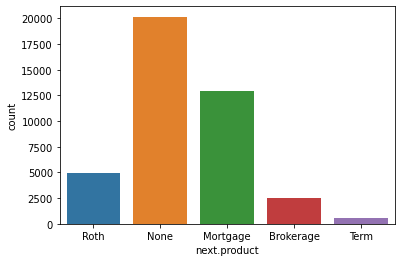

In [9]:
sns.countplot(x=df['next.product'])

<AxesSubplot:title={'center':'Distribution of Products by nr.employed'}, xlabel='nr.employed', ylabel='Count'>

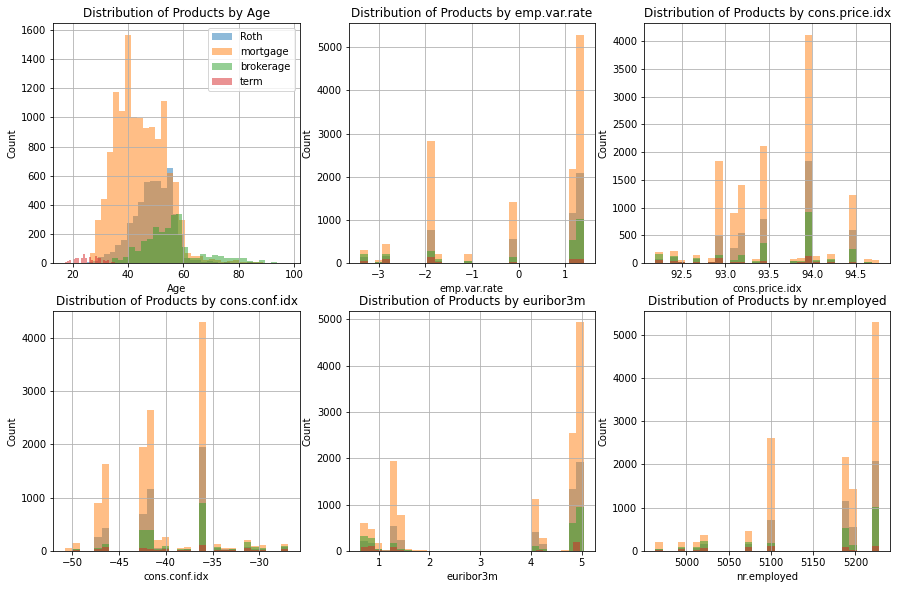

In [10]:
# EDA on numeric vars!!!
fig = plt.figure(figsize=(15,15))

# Age
ax1 = fig.add_subplot(331) # 3 rows, 3 cols, position 1
ax1.set_title("Distribution of Products by Age")
ax1.set_xlabel('Age')
ax1.set_ylabel('Count')
numeric_dict['age_roth'].hist(alpha=0.5, bins=30, label='Roth')
numeric_dict['age_mortgage'].hist(alpha=0.5, bins=30, label='mortgage')
numeric_dict['age_brokerage'].hist(alpha=0.5, bins=30, label='brokerage')
numeric_dict['age_term'].hist(alpha=0.5, bins=30, label='term')
plt.legend(loc='upper right')

# employment variation rate - quarterly indicator
ax2 = fig.add_subplot(332)
ax2.set_title("Distribution of Products by emp.var.rate")
ax2.set_xlabel('emp.var.rate')
ax2.set_ylabel('Count')
numeric_dict['emp.var.rate_roth'].hist(alpha=0.5, bins=30, label='Roth')
numeric_dict['emp.var.rate_mortgage'].hist(alpha=0.5, bins=30, label='mortgage')
numeric_dict['emp.var.rate_brokerage'].hist(alpha=0.5, bins=30, label='brokerage')
numeric_dict['emp.var.rate_term'].hist(alpha=0.5, bins=30, label='term')

# consumer price index - monthly indicator
ax3 = fig.add_subplot(333)
ax3.set_title("Distribution of Products by cons.price.idx")
ax3.set_xlabel('cons.price.idx')
ax3.set_ylabel('Count')
numeric_dict['cons.price.idx_roth'].hist(alpha=0.5, bins=30, label='Roth')
numeric_dict['cons.price.idx_mortgage'].hist(alpha=0.5, bins=30, label='mortgage')
numeric_dict['cons.price.idx_brokerage'].hist(alpha=0.5, bins=30, label='brokerage')
numeric_dict['cons.price.idx_term'].hist(alpha=0.5, bins=30, label='term')

# consumer confidence index - monthly indicator
ax4 = fig.add_subplot(334)
ax4.set_title("Distribution of Products by cons.conf.idx")
ax4.set_xlabel('cons.conf.idx')
ax4.set_ylabel('Count')
numeric_dict['cons.conf.idx_roth'].hist(alpha=0.5, bins=30, label='Roth')
numeric_dict['cons.conf.idx_mortgage'].hist(alpha=0.5, bins=30, label='mortgage')
numeric_dict['cons.conf.idx_brokerage'].hist(alpha=0.5, bins=30, label='brokerage')
numeric_dict['cons.conf.idx_term'].hist(alpha=0.5, bins=30, label='term')

# euribor 3 month rate - daily indicator
ax5 = fig.add_subplot(335)
ax5.set_title("Distribution of Products by euribor3m")
ax5.set_xlabel('euribor3m')
ax5.set_ylabel('Count')
numeric_dict['euribor3m_roth'].hist(alpha=0.5, bins=30, label='Roth')
numeric_dict['euribor3m_mortgage'].hist(alpha=0.5, bins=30, label='mortgage')
numeric_dict['euribor3m_brokerage'].hist(alpha=0.5, bins=30, label='brokerage')
numeric_dict['euribor3m_term'].hist(alpha=0.5, bins=30, label='term')

# number of employees - quarterly indicator
ax6 = fig.add_subplot(336)
ax6.set_title("Distribution of Products by nr.employed")
ax6.set_xlabel('nr.employed')
ax6.set_ylabel('Count')
numeric_dict['nr.employed_roth'].hist(alpha=0.5, bins=30, label='Roth')
numeric_dict['nr.employed_mortgage'].hist(alpha=0.5, bins=30, label='mortgage')
numeric_dict['nr.employed_brokerage'].hist(alpha=0.5, bins=30, label='brokerage')
numeric_dict['nr.employed_term'].hist(alpha=0.5, bins=30, label='term')

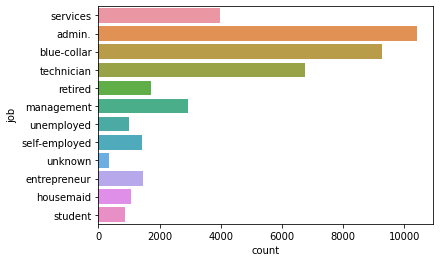

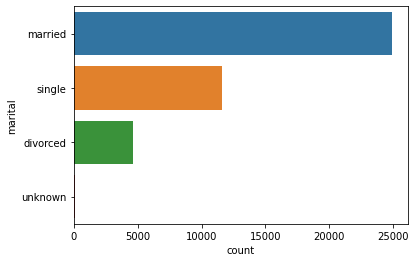

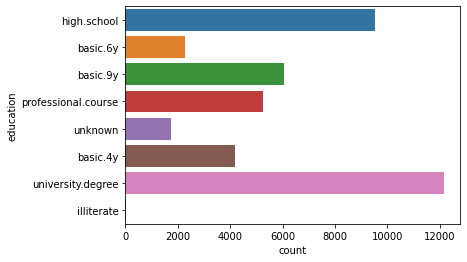

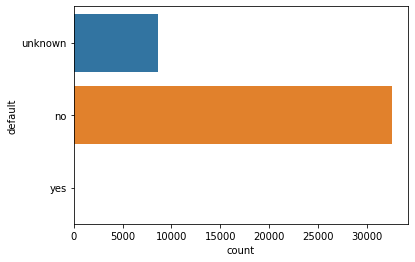

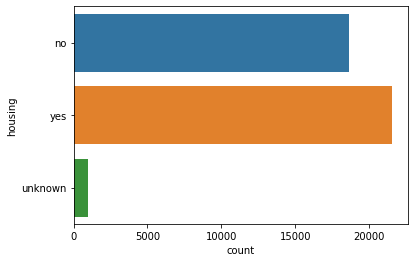

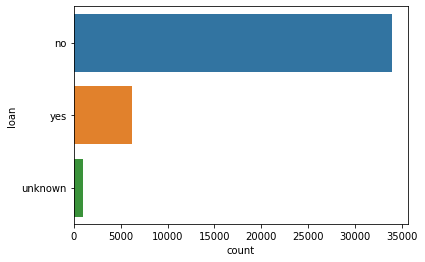

In [11]:
# EDA on categorical vars
categorical_df = df[categorical_vars]

for i, col in enumerate(categorical_df.columns):
    plt.figure(i)
    sns.countplot(y = col, data = categorical_df)

In [12]:
# Remove observations with 'none' for next.product since we are focusing on those to are likely to purchase
products_only = df[~(df['next.product']=='None')]

# Target variable
target = products_only['next.product']

# Get list of predictor vars
x_df = products_only[products_only.columns.difference(['next.product'])]

# Make categorical vars into numeric
encoded_df = pd.get_dummies(x_df, columns=categorical_vars)

# Split data into training and testing sets using default 75/25 split
x_train, x_test, y_train, y_test = train_test_split(encoded_df, target, random_state=1)

In [13]:
# See if gini or entropy tree gives better accuracy: entropy is slightly better!
dtree = DecisionTreeClassifier(min_samples_leaf=20, criterion='gini')
dtree.fit(x_train, y_train)
pred = dtree.predict(x_test)
print('Criterion=gini', accuracy_score(y_test, pred))

dtree = DecisionTreeClassifier(min_samples_leaf=20, criterion='entropy')
dtree.fit(x_train, y_train)
pred = dtree.predict(x_test)
print('Criterion=entropy', accuracy_score(y_test, pred))

Criterion=gini 0.9724124809741248
Criterion=entropy 0.9735540334855404


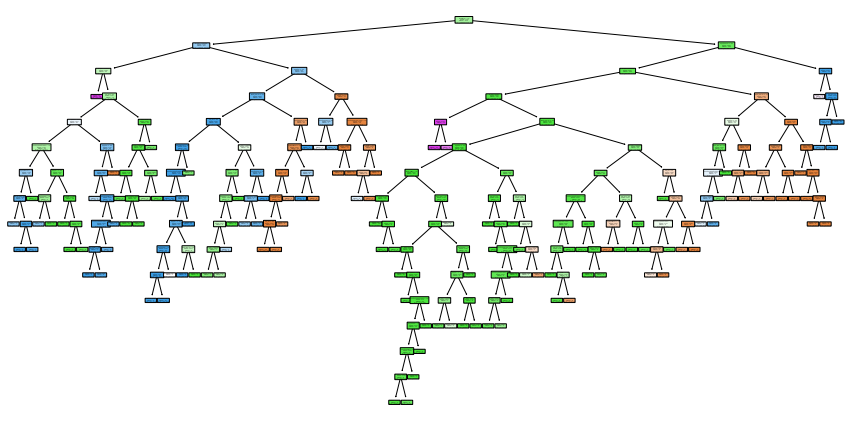

In [14]:
# Create a preliminary decision tree with min of 20 obs per leaf and fit it to the training data
clf = DecisionTreeClassifier(min_samples_leaf=20, random_state=1, criterion='entropy')
clf.fit(x_train, y_train) # fit to training data

# We can plot the tree and it is HUGE
plt.figure(figsize=(15, 7.5))

# Pass tree from training data to sklearn plot_tree() with parameters making it easier to look at
plot_tree(clf,
         filled = True,
         rounded = True,
         feature_names = x_train.columns);

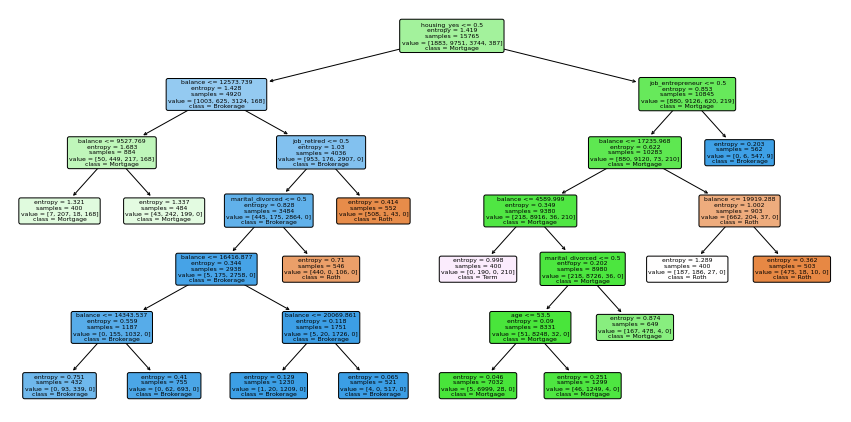

In [15]:
# Prune decision tree by setting 400 obs per leaf as min and other limitations, then fit it to the training data
clf = DecisionTreeClassifier(min_samples_leaf=400, max_depth=6, random_state=1, criterion='entropy')
clf.fit(x_train, y_train) # fit to training data

plt.figure(figsize=(15, 7.5))

# pass tree from training data to sklearn plot_tree() with parameters making it easier to look at
plot_tree(clf,
         filled = True,
         rounded = True,
          class_names = y_train.unique(),
         feature_names = x_train.columns);

In [16]:
# Compute accuracy using entropy decision tree
pred = clf.predict(x_test)
print('Entropy Accuracy:', accuracy_score(y_test, pred))

Entropy Accuracy: 0.903158295281583


In [17]:
# Function to display and save tree plot
def show_tree(tree, features, path):
    f = io.StringIO()
    export_graphviz(tree, 
                    filled=True,
                    rounded=True,
                    out_file=f, 
                    feature_names=features, 
                    class_names=y_train.unique())
    pydotplus.graph_from_dot_data(f.getvalue()).write_png(path)
    img = imageio.imread(path)
    plt.rcParams['figure.figsize'] = (20,20)
    plt.imshow(img)

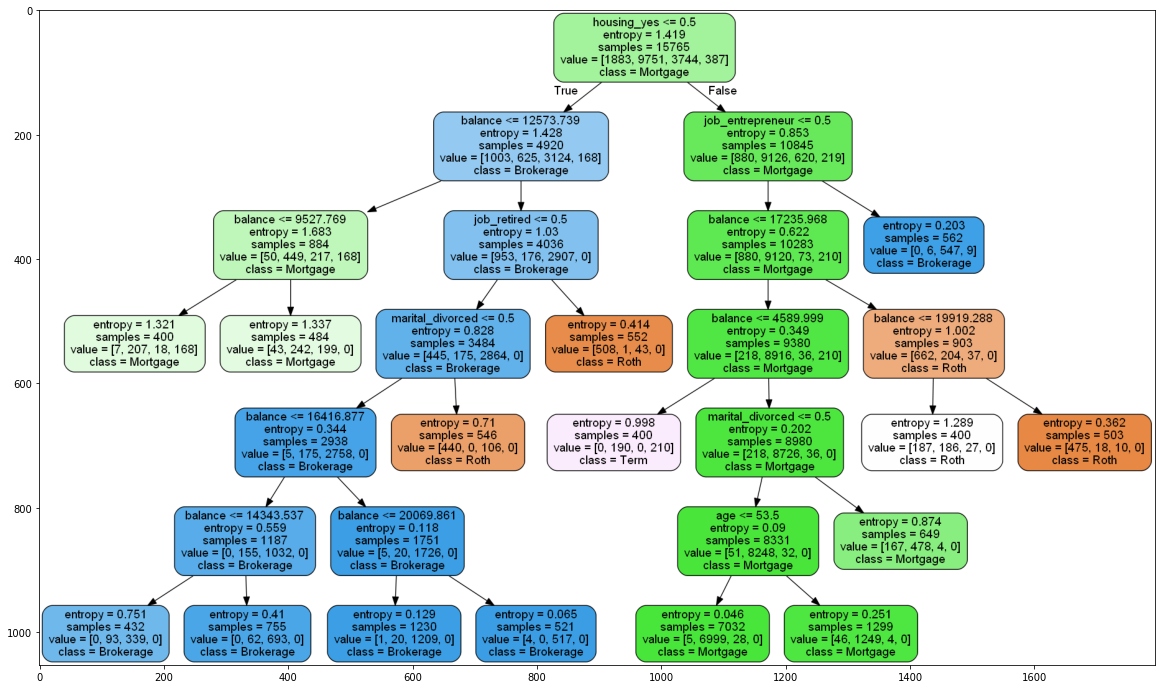

In [18]:
show_tree(clf, x_train.columns, "dt.png")

### Additional Information:

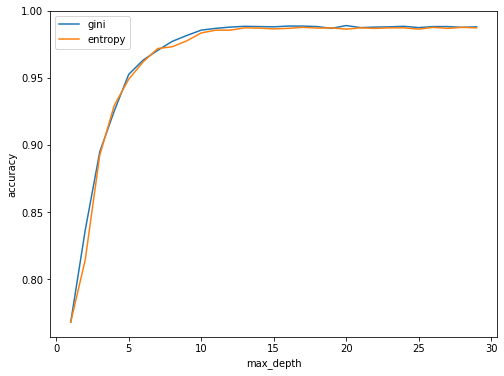

In [19]:
"""
Run our model using different values for max_depth (from 1 to 30) and 
visualize its results to see how the accuracy differs for each value.

source: https://towardsdatascience.com/decision-tree-build-prune-and-visualize-it-using-python-12ceee9af752

"""
max_depth = []
acc_gini = []
acc_entropy = []

for i in range(1,30):
    
    # Make dts using gini with each iteration
    dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
    dtree.fit(x_train, y_train)
    # Get accuracy score
    pred = dtree.predict(x_test)
    # Add accuracy score to gini list
    acc_gini.append(accuracy_score(y_test, pred))
    
    # Make dts using entropy with each iteration
    dtree = DecisionTreeClassifier(criterion='entropy', max_depth=i)
    dtree.fit(x_train, y_train)
    # Get accuracy score
    pred = dtree.predict(x_test)
    # Add accuracy score to entropy list
    acc_entropy.append(accuracy_score(y_test, pred))
    
    # Add value used for max depth to list
    max_depth.append(i)
    
# Create df of accuracy scores from both gini and entropy along with corresponding max depth value
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini),
                  'acc_entropy':pd.Series(acc_entropy), 
                  'max_depth':pd.Series(max_depth)})


# visualizing changes in parameters
fig = plt.figure(figsize=(8,6))
plt.plot('max_depth', 'acc_gini', data=d, label='gini')
plt.plot('max_depth', 'acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()

# From the plot, we see that both methods are VERY CLOSE...let's try max_depth of 6

In [20]:
# Weakest link pruning
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

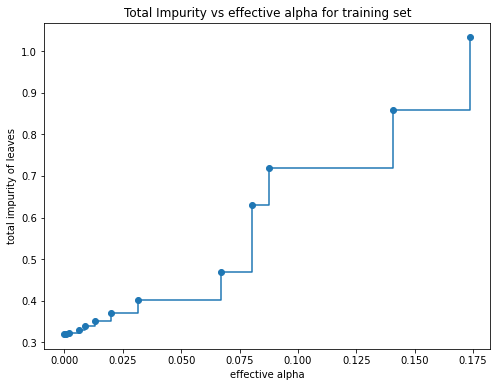

In [21]:
# max alpha is removed because it is a trivial tree with only one node.
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [22]:
""" Train a decision tree using the effective alphas.
The last value in ccp_alphas is the alpha value that prunes the whole tree, leaving the tree, clfs[-1], with one node.
"""
clfs = []

for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(x_train, y_train)
    clfs.append(clf)
    
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
      clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.38600975027953366


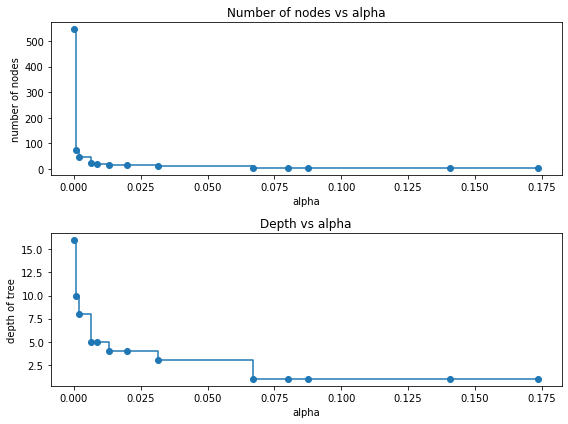

In [23]:
"""We removed the last element in clfs and ccp_alphas, because it is the trivial tree with only one node. 
Here we show that the number of nodes and tree depth decreases as alpha increases."""

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize=(8,6))
ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

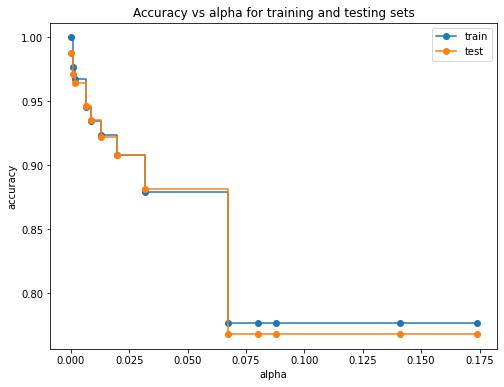

In [24]:
train_scores = [clf.score(x_train, y_train) for clf in clfs]
test_scores = [clf.score(x_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(8,6))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker='o', label="train",
        drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker='o', label="test",
        drawstyle="steps-post")
ax.legend()
plt.show()

In [25]:
# Dataquest functions for computing entropy, info gain, and best column

"""Calculate entropy given a pandas series, list, or numpy array"""

def calc_entropy(column):
    counts = np.bincount(column)
    probs = counts / len(column)
    entropy = 0
    for prob in probs:
        if prob > 0:
            entropy += prob * math.log(prob, 2)
    return -entropy

"""Calculate information gain given a data set, column to split on, and target"""

def calc_information_gain(data, split_name, target_name):
    
    # Get entropy using entropy fx
    original_entropy = calc_entropy(data[target_name])
    # Assign column to split on as column
    column = data[split_name]
    # Calculate median of column
    median = column.median()
    
    # Assign values <= to median to left split
    left_split = data[column <= median]
    # Assign values > median to right split
    right_split = data[column > median]
    
    # initalize to_subtract
    to_subtract = 0
    
    for subset in [left_split, right_split]:
        prob = (subset.shape[0] / data.shape[0])
        to_subtract += prob * calc_entropy(subset[target_name])
    return original_entropy - to_subtract

"""Finding the best column to split on given data set, target, and list of columns"""

def find_best_column(data, target_name, columns):
    
    # initialize list for information gains
    information_gains = []
    # compute information gain using custom fx for each predictor col and append to list
    for col in columns:
        information_gain = calc_information_gain(data, col, target_name)
        information_gains.append(information_gain)

    # Get index of highest information gains within list
    highest_gain_index = information_gains.index(max(information_gains))
    # Get column corresponding with highest gain index
    highest_gain = columns[highest_gain_index]
    return highest_gain